In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
from tqdm.auto import tqdm
from ipywidgets import *

from shortfall.consts import *
from shortfall.strategy import *
import shortfall.gradient.base_cost_models as bcm
import shortfall.gradient.optimize_burn as ob

In [3]:
initial_pledge_projection_period_days = 20
supply_lock_target = 0.3

# define various loss functions to explore
sampling_rate = 30  # sampling rate of the income curve

pledge_limited_base = StrategyConfig.pledge_limited(1000.0, 3 * YEAR, False)
pledge_limited_shortfall = StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True)
power_limited_base = StrategyConfig.power_limited(100 * TIBIBYTE / EXBIBYTE, 3 * YEAR, False)
power_limited_shortfall = StrategyConfig.power_limited(100 * TIBIBYTE / EXBIBYTE, 3 * YEAR, True)

def get_base_income(x):
    pledge_limited_base_stats = bcm.compute_baseline(initial_pledge_projection_period_days, supply_lock_target,
                                      strategy=pledge_limited_base)
    pledge_limited_income_base = bcm.compute_income_borrow_apy(pledge_limited_base_stats, borrow_amt=bcm.BORROW_AMT, apy=bcm.APY, sampling_rate_days=bcm.SAMPLING_RATE_DAYS)
    power_limited_base_stats = bcm.compute_baseline(initial_pledge_projection_period_days, supply_lock_target,
                                      strategy=power_limited_base)
    power_limited_income_base = bcm.compute_income_borrow_apy(power_limited_base_stats, borrow_amt=bcm.BORROW_AMT, apy=bcm.APY, sampling_rate_days=bcm.SAMPLING_RATE_DAYS)
    
    return pledge_limited_income_base, power_limited_income_base
    
def get_burn_income(x):
    
    pledge_limited_burn_stats = ob.compute_burn(x, strategy=pledge_limited_shortfall)
    indices = np.arange(sampling_rate, len(pledge_limited_burn_stats), sampling_rate)
    pledge_limited_income_shortfall = jnp.asarray([pledge_limited_burn_stats[ii]['net_equity'] for ii in indices])
    
    power_limited_burn_stats = ob.compute_burn(x, strategy=power_limited_shortfall)
    indices = np.arange(sampling_rate, len(power_limited_burn_stats), sampling_rate)
    power_limited_income_shortfall = jnp.asarray([power_limited_burn_stats[ii]['net_equity'] for ii in indices])
    
#     pledge_burn = burn_stats[0]['pledge_locked']
#     qap_burn = burn_stats[0]['power_eib']
    
    return pledge_limited_income_shortfall, power_limited_income_shortfall

# def normalize_income(income, pledge, qap):
#     income_per_pledge = income / pledge
#     income_per_qap = income / qap
    
#     return income_per_pledge, income_per_qap, income

x_noop = []
# income_base, pledge_base, qap_base = get_base_income(x_noop)
# base_income_per_pledge, base_income_per_QAP, base_income_raw = normalize_income(income_base, pledge_base, qap_base)
base_income_per_pledge, base_income_per_QAP = get_base_income(x_noop)

def loss_fn(x, w):
    burn_income_per_pledge, burn_income_per_QAP = get_burn_income(x)
    
    w1 = w
    w2 = 1. - w1
    
    O1 = np.linalg.norm(base_income_per_QAP - 0.8*burn_income_per_QAP) # in power-limited case, we want shortfall to be 10% less effective
    O2 = np.linalg.norm(burn_income_per_pledge - 0.8*base_income_per_pledge) # in pledge-limited case, we want shortfall to be profitable    
    loss = w1 * O1 + w2 * O2

    return loss

In [4]:
w_vec = np.linspace(0,1,11)

results_dict = {}

for w in tqdm(w_vec):
    max_shortfall_fraction_vec = np.linspace(0.1, 0.5, 10)
    shortfall_pct_pow_vec = np.linspace(0, 1, 8)

    loss_surface = np.zeros((len(max_shortfall_fraction_vec), len(shortfall_pct_pow_vec)))
    for ii in range(len(max_shortfall_fraction_vec)):
        for jj in range(len(shortfall_pct_pow_vec)):
            x = jnp.asarray([max_shortfall_fraction_vec[ii], shortfall_pct_pow_vec[jj]])
            loss_surface[ii,jj] = loss_fn(x, w)
            
    # get the best/worst param curves
    min_ii, min_jj = np.unravel_index(loss_surface.argmin(), loss_surface.shape)
    best_shortfall_frac = max_shortfall_fraction_vec[min_ii]
    best_shortfall_pct_pow = shortfall_pct_pow_vec[min_jj]

    max_ii, max_jj = np.unravel_index(loss_surface.argmax(), loss_surface.shape)
    worst_shortfall_frac = max_shortfall_fraction_vec[max_ii]
    worst_shortfall_pct_pow = shortfall_pct_pow_vec[max_jj]

    # get the best params curves
    best_burn_income_per_pledge, best_burn_income_per_QAP = get_burn_income(jnp.asarray([best_shortfall_frac, best_shortfall_pct_pow]))
    worst_burn_income_per_pledge, worst_burn_income_per_QAP = get_burn_income(jnp.asarray([worst_shortfall_frac, worst_shortfall_pct_pow]))
    
    out_dict = {
        'loss_surface': loss_surface,
        'best_burn_income_per_pledge': best_burn_income_per_pledge,
        'best_burn_income_per_QAP': best_burn_income_per_QAP,
        'worst_burn_income_per_pledge': worst_burn_income_per_pledge,
        'worst_burn_income_per_QAP': worst_burn_income_per_QAP,
        'min_ii': min_ii,
        'min_jj': min_jj,
        'max_ii': max_ii,
        'max_jj': max_jj
    }
    results_dict[w] = out_dict

  0%|          | 0/11 [00:00<?, ?it/s]

In [6]:
with open('optimize_burn.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

In [7]:
with open('optimize_burn.pkl', 'rb') as f:
    results_dict = pickle.load(f)

<IPython.core.display.Javascript object>


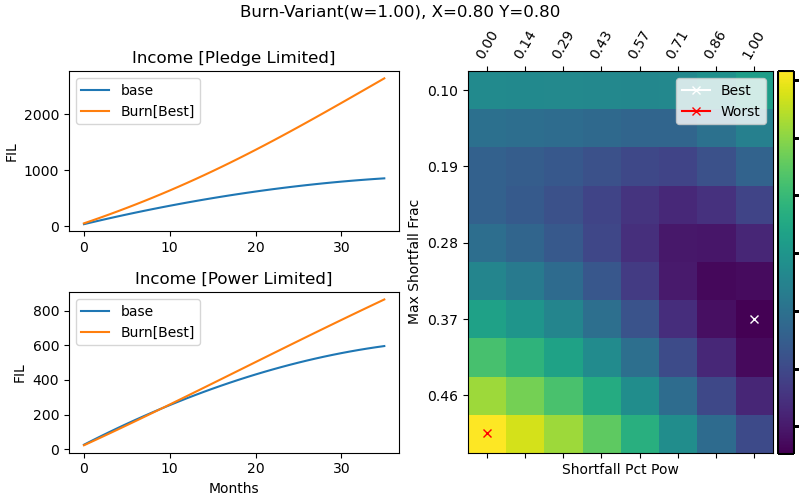

interactive(children=(FloatSlider(value=0.5, description='w', max=1.0), Output()), _dom_classes=('widget-inter…

<function __main__.update(w=0.5)>

In [24]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                              figsize=(8, 5), layout="constrained")

ax1 = axd['upper left']
ax1.plot(base_income_per_pledge, label='base')
burn_pledge_limited, = ax1.plot(best_burn_income_per_pledge, label='Burn[Best]')
ax1.set_ylabel('FIL')
ax1.set_title('Income [Pledge Limited]')
ax1.legend()

ax2 = axd['lower left']
ax2.plot(base_income_per_QAP, label='base')
burn_power_limited, = ax2.plot(best_burn_income_per_QAP, label='Burn[Best]')
ax2.set_title('Income [Power Limited]')
ax2.set_ylabel('FIL')
ax2.legend()
ax2.set_xlabel('Months')

xt = ['%0.02f' % (x,) for x in shortfall_pct_pow_vec]
yt = ['%0.02f' % (x,) for x in max_shortfall_fraction_vec]
ax3 = axd['right']
z = ax3.matshow(loss_surface)
ax3.set_xticks(range(len(xt)))
ax3.set_yticks(range(len(yt)))
ax3.set_xticklabels(xt, rotation=60)
ax3.set_yticklabels(yt)
ax3.set_xlabel('Shortfall Pct Pow')
ax3.set_ylabel('Max Shortfall Frac')
# ax.scatter([find_closest_idx(token_lease_fee_vec, 0.3)], 
#            [find_closest_idx(max_fee_reward_fraction_vec, 0.25)], color='red', marker='x', label='Alex')
best_point, = ax3.plot([min_jj], [min_ii], color='white', marker='x', label='Best')
worst_point, = ax3.plot([max_jj], [max_ii], color='red', marker='x', label='Worst')
ax3.legend()

plt.suptitle('Burn-Variant(w=0.5), X=%0.02f Y=%0.02f' % (0.8, 0.8))

def get_closest_key(key_in):
    keys = np.asarray(list(results_dict.keys()))
    ii = np.argmin(np.abs(keys-key_in))
    return keys[ii]

def update(w=0.5):
    w_in = get_closest_key(w)
    res_dict = results_dict[w_in]
    loss_surface = res_dict['loss_surface']
    best_burn_income_per_pledge = res_dict['best_burn_income_per_pledge']
    best_burn_income_per_QAP = res_dict['best_burn_income_per_QAP']
    min_ii = res_dict['min_ii'] 
    min_jj = res_dict['min_jj']
    max_ii = res_dict['max_ii'] 
    max_jj = res_dict['max_jj']
    
    best_point.set_data([min_jj], [min_ii])
    worst_point.set_data([max_jj], [max_ii])
    
    burn_pledge_limited.set_ydata(best_burn_income_per_pledge)
    burn_power_limited.set_ydata(best_burn_income_per_QAP)
    ax3.matshow(loss_surface)
    
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(z, cax=cax, orientation='vertical')


    plt.suptitle('Burn-Variant(w=%0.02f), X=%0.02f Y=%0.02f' % (w, 0.8, 0.8))
    fig.canvas.draw_idle()


interact(update, w=(0,1,0.1))